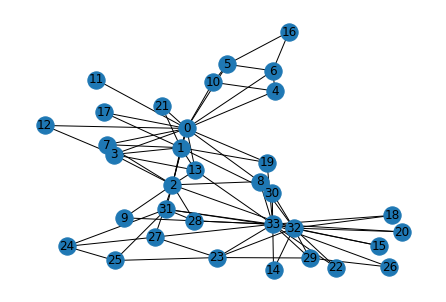

In [201]:
import networkx as nx

G = nx.karate_club_graph()
nx.draw(G, with_labels=True)

In [185]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import numpy as np

torch.__version__

'1.11.0'

In [186]:
# 拉普拉斯归一化操作
def norm(adj):
    # 给每个节点增加闭环
    adj += np.eye(adj.shape[0])
    # 为每个节点计算度
    degree = np.array(adj.sum(1))
    degree = np.diag(np.power(degree, -0.5))
    return degree.dot(adj).dot(degree)


# 卷积层设计
class GraphConvolution(nn.Module):
    def __init__(self, input_size, output_size):
        super(GraphConvolution, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, adj, features):
        out = torch.mm(adj, features)
        out = self.linear(out)
        return out


# GCN设计
class GCN(nn.Module):
    def __init__(self, input_size=34, hidden_size=5):
        super(GCN, self).__init__()
        self.gcn1 = GraphConvolution(input_size, hidden_size)
        self.gcn2 = GraphConvolution(hidden_size, 2)

    def forward(self, adj, features):
        out = F.relu(self.gcn1(adj, features))
        out = self.gcn2(adj, out)
        return out


In [187]:
LEARNING_RATE = 0.1
WEIGHT_DACAY = 5e-4
EPOCHS = 50
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [202]:
features = np.eye(34, dtype=np.float)

y = np.zeros(G.number_of_nodes())
for i in range(G.number_of_nodes()):
    if G.nodes[i]['club'] == 'Mr. Hi':
        y[i] = 0
    else:
        y[i] = 1

adj = np.zeros((34, 34))  # 邻阶矩阵
for k, v in G.adj.items():
    for item in v.keys():
        adj[k][item] = 1
adj = norm(adj)

C:\Users\18456\anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


array([[0.05882353, 0.0766965 , 0.07312724, ..., 0.09166985, 0.        ,
        0.        ],
       [0.0766965 , 0.1       , 0.09534626, ..., 0.        , 0.        ,
        0.        ],
       [0.07312724, 0.09534626, 0.09090909, ..., 0.        , 0.0836242 ,
        0.        ],
       ...,
       [0.09166985, 0.        , 0.        , ..., 0.14285714, 0.10482848,
        0.08908708],
       [0.        , 0.        , 0.0836242 , ..., 0.10482848, 0.07692308,
        0.06537205],
       [0.        , 0.        , 0.        , ..., 0.08908708, 0.06537205,
        0.05555556]])

In [189]:
features = torch.tensor(features, dtype=torch.float).to(DEVICE)
y = torch.tensor(y, dtype=torch.long).to(DEVICE)
adj = torch.tensor(adj, dtype=torch.float).to(DEVICE)

In [190]:
net = GCN().to(DEVICE)
loss = nn.CrossEntropyLoss().to(DEVICE)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DACAY)


def train():
    for epoch in range(EPOCHS):
        out = net(adj, features)
        mask = [False if x != 0 and x != 33 else True for x in range(34)]  # 只选择管理员和教练进行训练
        l = loss(out[mask], y[mask])
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        print(f"epoch: {epoch}, loss: {l.item()}")


train()

epoch: 0, loss: 0.716529369354248
epoch: 1, loss: 0.6777296662330627
epoch: 2, loss: 0.6629503965377808
epoch: 3, loss: 0.6056697368621826
epoch: 4, loss: 0.4942358732223511
epoch: 5, loss: 0.36204564571380615
epoch: 6, loss: 0.25393226742744446
epoch: 7, loss: 0.1727457344532013
epoch: 8, loss: 0.09504758566617966
epoch: 9, loss: 0.044941700994968414
epoch: 10, loss: 0.02029130607843399
epoch: 11, loss: 0.009631017223000526
epoch: 12, loss: 0.005079236812889576
epoch: 13, loss: 0.0029711450915783644
epoch: 14, loss: 0.001888567116111517
epoch: 15, loss: 0.0012783179990947247
epoch: 16, loss: 0.0009066630736924708
epoch: 17, loss: 0.0006729469751007855
epoch: 18, loss: 0.0005161073058843613
epoch: 19, loss: 0.00041111119207926095
epoch: 20, loss: 0.00033790760789997876
epoch: 21, loss: 0.00028745215968228877
epoch: 22, loss: 0.0002530184283386916
epoch: 23, loss: 0.00023008127755019814
epoch: 24, loss: 0.00021596103033516556
epoch: 25, loss: 0.00020839431090280414
epoch: 26, loss: 0.00

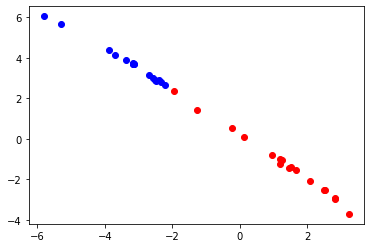

In [191]:
r = net(adj, features).cpu().detach().numpy()
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(34):
    plt.scatter(r[i][0], r[i][1], color="r" if y[i] == 0 else 'b')
plt.show()